In [147]:
# check version number
import imblearn
print(imblearn.__version__)

0.10.1


In [148]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

In [149]:

df = pd.read_csv('/Users/youli/Desktop/UC_Irvine/WQ_2023/CS273P/project/jigsaw-toxic-comment-classification-challenge-2/train.csv')


labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


X = df.drop(labels, axis=1)
y = df[labels]


label_counts = y.apply(pd.Series.value_counts)


print(label_counts)

    toxic  severe_toxic  obscene  threat  insult  identity_hate
0  144277        157976   151122  159093  151694         158166
1   15294          1595     8449     478    7877           1405


In [150]:

from sklearn.preprocessing import MultiLabelBinarizer

#sum all cols to total
mlb = MultiLabelBinarizer()
sum_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df.loc[(df[sum_cols].sum(axis=1)) > 0, 'total'] = 1
df.loc[(df[sum_cols].sum(axis=1)) == 0, 'total'] = 0

from imblearn.under_sampling import RandomUnderSampler

#To create the feature set
features = df['comment_text'].values.reshape(-1, 1)

#To create the labels set
labels = df['total'].values

#undersample
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(features, labels)


print(f"X_resampled.shape: {X_resampled.shape}")
print(f"y_resampled.shape: {y_resampled.shape}")

X_resampled.shape: (32450, 1)
y_resampled.shape: (32450,)


In [162]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers



# Load the data
df = pd.read_csv('/Users/youli/Desktop/UC_Irvine/WQ_2023/CS273P/project/jigsaw-toxic-comment-classification-challenge-2/train.csv')

sum_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Create a new column 'total' containing 1 if any of the sum_cols has a non-zero value, and 0 otherwise
df['total'] = df[sum_cols].apply(lambda x: 1 if sum(x) > 0 else 0, axis=1)

# Undersample the data
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled_total = rus.fit_resample(df['comment_text'].values.reshape(-1, 1), df['total'].values)

# Get the index of resampled data
resampled_indices = rus.sample_indices_

# Extract the original multi-label format using the resampled indices
y_resampled = df.loc[resampled_indices, sum_cols].values

# Tokenize the text data
MAX_NUM_WORDS = 2000
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_resampled.flatten())
sequences = tokenizer.texts_to_sequences(X_resampled.flatten())

# Pad the sequences
MAX_SEQUENCE_LENGTH = 200
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)


In [210]:
# Build the model
word_index = tokenizer.word_index
model = Sequential()
model.add(layers.Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=MAX_SEQUENCE_LENGTH))
model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(6, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
EPOCHS = 30
BATCH_SIZE = 128
history = model.fit(data, y_resampled, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)



Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 200, 100)          7114100   
                                                                 
 conv1d_35 (Conv1D)          (None, 196, 128)          64128     
                                                                 
 global_max_pooling1d_34 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_280 (Dense)           (None, 128)               16512     
                                                                 
 dropout_102 (Dropout)       (None, 128)               0         
                                                                 
 dense_281 (Dense)           (None, 64)                8256      
                                                     

In [212]:
# Load the test data
test_df=pd.read_csv('/Users/youli/Desktop/UC_Irvine/WQ_2023/CS273P/project/jigsaw-toxic-comment-classification-challenge-2/test.csv')
test_labels_df = pd.read_csv('/Users/youli/Desktop/UC_Irvine/WQ_2023/CS273P/project/jigsaw-toxic-comment-classification-challenge-2/test_labels.csv')

merged_test_df = test_df.merge(test_labels_df, on='id')

# Prepare the test data
test_comment_texts = merged_test_df['comment_text'].values
test_sequences = tokenizer.texts_to_sequences(test_comment_texts)
X_test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Predict probabilities for the test data
probabilities = model.predict(X_test_padded)

# Create the result dataframe
result = pd.DataFrame(probabilities, columns=sum_cols)
result.insert(0, 'id', merged_test_df['id'])

4787/4787 [==============================] - 19s 4ms/step


In [215]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


y_test = merged_test_df[sum_cols].values


known_label_indices = np.where(np.all(y_test != -1, axis=1))[0]
y_test_filtered = y_test[known_label_indices]
predictions_filtered = predictions[known_label_indices]
probabilities_filtered = probabilities[known_label_indices]


threshold = 0.6
predictions_filtered = (probabilities_filtered > threshold).astype(int)


accuracy = accuracy_score(y_test_filtered, predictions_filtered)
precision = precision_score(y_test_filtered, predictions_filtered, average='micro', zero_division=0)
recall = recall_score(y_test_filtered, predictions_filtered, average='micro', zero_division=0)
f1 = f1_score(y_test_filtered, predictions_filtered, average='micro', zero_division=0)
roc_auc = roc_auc_score(y_test_filtered, probabilities_filtered, average='macro', multi_class='ovr')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'ROC-AUC score: {roc_auc:.2f}')



Accuracy: 0.79
Precision: 0.42
Recall: 0.70
F1-score: 0.53
ROC-AUC score: 0.94


In [158]:
predictions.shape

(153164, 6)

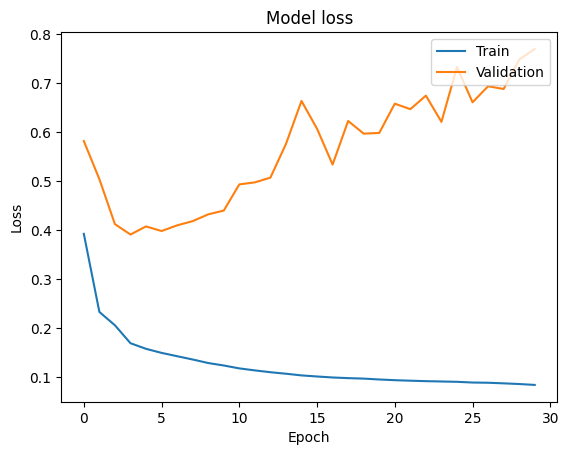

In [216]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
